<a ><img src="Pictures/trashpanda.png"  width="70" align="left"> </a>
<div style="text-align: right"> <h3><span style="color:gray"> DRAFT </span> </h3> </div>

<br>
<br>
<br>

<a ><img src="Pictures/Icon.png" Width="250" align="center"> </a>

<br>
<br>



<h1><center>Sentiment Analysis</center></h1>
<h2><center> <span style="font-weight:normal"><font color='#022F73'> 
Natural language processing (NLP): <br> Analysis of Headlines with VADER and pysentiment </font>  </span></center></h2>


<h3><center><font color='gray'>JONAS GOTTAL</font></center></h3>

<h4>About this Notebook</h4>
We will conduct a sentiment Analysis with VADER  <br> 
(Valence Aware Dictionary for Sentiment Reasoning) and FinBERT, a pre-trained Model,<br>  
on headlines of several different news outlets with impact on german financial markets <br> 
and generate for each a dedicated sentiment KPI per trading day. In the end we will have <br> a sound time series  and - hopefully - some predictive results.
<br>
<br>


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="text-decoration:none; margin-top: 30px; background-color:#F2F2F2; border-color:#022F73">
    <span style="color:#022F73">
    <ol>
      <li><a href="#1"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Motivation  </span> </a></li>
      <li><a href="#2"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Approach  </span> </a></li>
      <li><a href="#3"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Sentiment Scores with VADER and pysentiment</span> </a></li>
      <li><a href="#4"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Upload on our MySQL Database</span> </a></li>
      <li><a href="#5"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Schedule daily runs as .py script</span> </a></li>
      <li><a href="#6"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Upcoming Analysis of our unique dataset</span> </a></li>
      <li><a href="#7"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Outlook</span> </a></li>
    </ol>
    </span>
</div>

In [1]:
#!pip install html5lib
#!pip install ipython-sql
#!pip install nltk
#! pip install pysentiment2

import requests
from   bs4 import BeautifulSoup
import html5lib
import time
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import dtale
import sqlalchemy
from sqlalchemy import create_engine
import pymysql
pymysql.install_as_MySQLdb()
import pysentiment2 as ps
import nltk
import re
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import seaborn as sns

# 1. Motivation <a id="1"></a>


> <i> "There are three ways to make a living in this business: be first, be smarter, or cheat. Well, I don't cheat. And although I like to think we have some pretty smart people here in this room, it sure is a hell of lot easier to just be first." </i> **- Margin Call** 

But to be the first to use market data, you would need to be in an optimal physical location (depending on the stock exchanges) and you have to have the fastest connection. Neither of those is true for me and many others. So to be successful - in this analogy of margin call - you would have to design/manipulate a unique set of data - and therefore be first again.

## Revision of our news scraping approach (see other notebook before)

#### Documentation: https://requests.readthedocs.io/en/master/user/advanced
```j
content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))
`````


### A. Bild

In [2]:
url = "https://www.bild.de/politik/international/bild-international/home-44225950.bild.html"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [3]:
bild = BeautifulSoup(content.content, 'html.parser')

headlines = bild.find_all(attrs={'class':'headline'})

df_bild = pd.DataFrame([i.text for i in headlines], columns=["bild"])
print (df_bild.size, df_bild.head())

12                                                 bild
0                  Bill Gates on conspiracy theories
1               “Run! The planes are bombing again!”
2                             Church bombed to ruins
3  „The city looks like German cities during the ...
4          Navalny: Sanction Putin's closest circle 


### B. Spiegel

In [4]:
url = "https://www.spiegel.de/international/"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [5]:
spiegel = BeautifulSoup(content.content, 'html.parser')

headlines = spiegel.find_all(attrs={'class':'align-middle'})

df_spiegel = pd.DataFrame([i.text for i in headlines], columns=["spiegel"])
print (df_spiegel.size, df_spiegel.head())

27                                              spiegel
0               A Country Slides Toward Dictatorship
1                      “How Can You Not Be Worried?”
2  EU Border Agency Frontex Complicit in Greek Re...
3             If That's the Future, then Good Night!
4             "There Will Be Unrest, Dead Civilians"


### C. Zeit

In [6]:
url = "https://www.zeit.de/english/index"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [7]:
zeit = BeautifulSoup(content.content, 'html.parser')

headlines = zeit.find_all(attrs={'class':'zon-teaser-standard__title'})

df_zeit = pd.DataFrame([i.text for i in headlines], columns=["zeit"])
print (df_zeit.size, df_zeit.head())

20                                                 zeit
0        All of Europe is talking about the pandemic
1                                   "It's Up To Us" 
2          "A President who is incapable of the job"
3  "Food Becomes Increasingly Important the More ...
4                  Exorcism in Lieu of Enlightenment


### D. FAZ

In [8]:
url = "https://www.faz.net/english/"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [9]:
faz = BeautifulSoup(content.content, 'html.parser')

headlines = faz.find_all(attrs={'class':'tsr-Base_HeadlineText'})

df_faz = pd.DataFrame([i.text for i in headlines], columns=["faz"]).replace("\n", "", regex=True).replace("\t", "", regex=True)
print (df_faz.size, df_faz.head())

20                                                  faz
0  „We have to fight misinformation because peopl...
1                  Do not ruin the Internet!        
2                              The Black Axe        
3  Time for a German-British Friendship Treaty   ...
4                 The Girl With The Red Coat        


### E. BBC

In [10]:
url = "https://www.bbc.com/news"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [11]:
bbc = BeautifulSoup(content.content, 'html.parser')

headlines = bbc.find_all('h3')

df_bbc = pd.DataFrame([i.text for i in headlines], columns=["bbc"])
print (df_bbc.size, df_bbc.head())

59                                                  bbc
0   Lockdowns return as Europe confronts second wave
1   Lockdowns return as Europe confronts second wave
2  Nearly 100,000 catching virus every day in Eng...
3  Trump slams lockdowns, Biden accuses him of in...
4   Al-Qaeda still 'heavily embedded' within Taliban


### F. CNN

In [12]:
url = "https://www.cnn.com/business"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [13]:
cnn = BeautifulSoup(content.content, 'html.parser')

headlines = cnn.find_all(attrs={'class': 'cd__headline'})

df_cnn = pd.DataFrame([i.text for i in headlines], columns=["cnn"])
print (df_cnn.size, df_cnn.head())

32                                                  cnn
0  Samsung reports bumper profits but warns of sl...
1  Ford returns to profitability as it blows past...
2  US stocks sold off sharply, with the Dow tumbl...
3  Wall Street is spooked, but should have seen t...
4  A deep recession should hurt Trump's reelectio...


### G. CNBC

In [14]:
url = "https://www.cnbc.com"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [15]:
cnbc = BeautifulSoup(content.content, 'html.parser')

headlines = cnbc.find_all(attrs={'class':'Card-title'})

df_cnbc = pd.DataFrame([i.text for i in headlines], columns=["cnbc"])
print (df_cnbc.size, df_cnbc.head())

34                                                 cnbc
0  Stocks making the biggest moves after hours: P...
1  Stocks are hit hard by virus, election, and th...
2  Dow sinks more than 900 points for its worst d...
3  Stock market live Wednesday: Stocks close near...
4  Coronavirus updates: U.S. records more than 80...


### H. New York Times

Due to its sound reputation we will also use the sub sections and not only the main site.

For us relevant: 
- World https://www.nytimes.com/section/world
- Politics https://www.nytimes.com/section/politics
- Business https://www.nytimes.com/section/business
- Tech https://www.nytimes.com/section/technology

In [16]:
url = "https://www.nytimes.com/section/world"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [17]:
nyt_w = BeautifulSoup(content.content, 'html.parser')

headlines = nyt_w.find_all(name="h2")

df_nyt_w = pd.DataFrame([i.text for i in headlines], columns=["nyt_w"]).iloc[1:].reset_index(drop=True)
print (df_nyt_w.size, df_nyt_w.head())

44                                                nyt_w
0  Polish Women Lead Strike Over Abortion Ruling ...
1  Former South Korean President Ordered Back to ...
2  France and Germany Lock Down as Second Coronav...
3  In Azerbaijan, a String of Explosions, Screams...
4  China’s Stance on Homosexuality Has Changed. I...


In [18]:
url = "https://www.nytimes.com/section/politics"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [19]:
nyt_p = BeautifulSoup(content.content, 'html.parser')

headlines = nyt_p.find_all(name="h2")

df_nyt_p = pd.DataFrame([i.text for i in headlines], columns=["nyt_p"]).iloc[1:].reset_index(drop=True)
print (df_nyt_p.size, df_nyt_p.head())

18                                                nyt_p
0  Miles Taylor, a Former Homeland Security Offic...
1  Biden Holds 8-Point Lead in Michigan as He Tri...
2  Trump’s Closing Argument on Virus Clashes With...
3  The 2020 Campaign Is the Most Expensive Ever (...
4        How Mail Votes Could Delay Election Results


In [20]:
url = "https://www.nytimes.com/section/business"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [21]:
nyt_b = BeautifulSoup(content.content, 'html.parser')

headlines = nyt_b.find_all(name="h2")

df_nyt_b = pd.DataFrame([i.text for i in headlines], columns=["nyt_b"]).iloc[1:].reset_index(drop=True)
print (df_nyt_b.size, df_nyt_b.head())

34                                                nyt_b
0  A Biden Win Could Renew a Democratic Split on ...
1  Social Security Seemed Like a Future Problem. ...
2  To Do Politics or Not Do Politics? Tech Start-...
3  France Braces for Economic Suffering as Lockdo...
4  Republicans Blast Social Media C.E.O.s While D...


In [22]:
url = "https://www.nytimes.com/section/technology"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [23]:
nyt_t = BeautifulSoup(content.content, 'html.parser')

headlines = nyt_t.find_all(name="h2")

df_nyt_t = pd.DataFrame([i.text for i in headlines], columns=["nyt_t"]).iloc[1:].reset_index(drop=True)
print (df_nyt_t.size, df_nyt_t.head())

23                                                nyt_t
0  Republicans Blast Social Media C.E.O.s While D...
1  To Do Politics or Not Do Politics? Tech Start-...
2       Trump Campaign Website Is Defaced by Hackers
3                   We Need Policy, Not WrestleMania
4                                Personal Technology


# 2. Approach <a id="2"></a>

> <i>"Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data." </i> - Wikipedia

Sentiment analysis is a text analysis method that detects polarity (e.g. a positive or negative opinion) within the text, whether a whole document, paragraph, sentence, or clause.

Sentiment analysis aims to measure the attitude, sentiments, evaluations, attitudes, and emotions of a speaker/writer based on the computational treatment of subjectivity in a text.

## ```VADER```

VADER ( Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is available in the ```NLTK``` package and can be applied directly to unlabeled text data.

VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text.

For example- Words like ‘love’, ‘enjoy’, ‘happy’, ‘like’ all convey a positive sentiment. Also VADER is intelligent enough to understand the basic context of these words, such as “did not love” as a negative statement. It also understands the emphasis of capitalization and punctuation, such as “ENJOY”

### Polarity classification

We won’t try to determine if a sentence is objective or subjective, fact or opinion. Rather, we care only if the text expresses a positive, negative or neutral opinion.

## ```pysentiment```

This is a library for sentiment analysis in dictionary framework. Two dictionaries are provided in the library, namely, *[Harvard IV-4](http://www.wjh.harvard.edu/~inquirer/homecat.htm)* and *[Loughran and McDonald Financial Sentiment Dictionaries](https://sraf.nd.edu/)*, which are sentiment dictionaries for general and financial sentiment analysis.

##### Introduction

```Positive``` and ```Negative``` are word counts for the words in positive and negative sets.

```Polarity``` and ```Subjectivity``` are calculated in the same way of [Lydia](http://www.cs.sunysb.edu/~skiena/lydia/) system.

The formula for Polarity is:

$$
Polarity = \frac{Pos - Neg}{Pos + Neg}
$$

The formula for Subjectivity is:

$$
Subjectivity = \frac{Pos + Neg}{count}
$$


# 3. Sentiment Scores  <a id="3"></a>

## ... with VADER <a id="3"></a>

Let's have a look at our polarity scores with VADER!

In [29]:
nltk.download("vader_lexicon")

def get_score(row):
    sid=SIA()
    score=sid.polarity_scores(row)
    return score["compound"]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jonas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [30]:
df_bild_score = df_bild["bild"].apply(get_score)
df_bild_final = pd.concat([df_bild, df_bild_score ], axis=1, sort=False).rename(columns={"bild": "bild", "bild": "score"}, errors="raise")

In [31]:
df_bild_final.head(10)

,score,score
0,Bill Gates on conspiracy theories,-0.5267
1,“Run! The planes are bombing again!”,0.0000
2,Church bombed to ruins,-0.4404
3,„The city looks like German cities during the ...,0.3612
4,Navalny: Sanction Putin's closest circle,0.0000
5,"China is celebrating, the world is suffering",0.1531
6,Why the US is withdrawing from the Open Skies ...,0.0000
7,The Thai king’s secret torture prison,-0.8020
8,„You are endangering the world“,0.0000
9,„There will be a time for assigning blame“,0.0000


Not surprising, that **torture**, **bombed to ruins** and **conspiracy theories** don't have the most positive connotation. 

In [32]:
daily_bild = df_bild_final["score"].mean()
daily_bild

score   -0.165825
dtype: float64

In [33]:
#To wrap it up:
bild_score = df_bild["bild"].apply(get_score)
daily_bild = bild_score.mean()
daily_bild

-0.165825

In [34]:
#Now for all:
#Bild
bild_score = df_bild["bild"].apply(get_score)
daily_bild = bild_score.mean()
#Spiegel
spiegel_score = df_spiegel["spiegel"].apply(get_score)
daily_spiegel = spiegel_score.mean()
#Zeit
zeit_score = df_zeit["zeit"].apply(get_score)
daily_zeit = zeit_score.mean()
#FAZ
faz_score = df_faz["faz"].apply(get_score)
daily_faz = faz_score.mean()
#BBC
bbc_score = df_bbc["bbc"].apply(get_score)
daily_bbc = bbc_score.mean()
#CNN
cnn_score = df_cnn["cnn"].apply(get_score)
daily_cnn = cnn_score.mean()
#CNBC
cnbc_score = df_cnbc["cnbc"].apply(get_score)
daily_cnbc = cnbc_score.mean()
#NYT World
nyt_w_score = df_nyt_w["nyt_w"].apply(get_score)
daily_nyt_w = nyt_w_score.mean()
#NYT Politics
nyt_p_score = df_nyt_p["nyt_p"].apply(get_score)
daily_nyt_p = nyt_p_score.mean()
#NYT Business
nyt_b_score = df_nyt_b["nyt_b"].apply(get_score)
daily_nyt_b = nyt_b_score.mean()
#NYT Tech
nyt_t_score = df_nyt_t["nyt_t"].apply(get_score)
daily_nyt_t = nyt_t_score.mean()

##### Lets add a Timestamp so we can use the Headlines as Timeseries

In [35]:
n = pd.to_datetime('today').strftime("%m/%d/%Y")
n

'10/29/2020'

In [36]:
ds = {'Timestamp':[n] ,'daily_bild':[daily_bild],'daily_spiegel':[daily_spiegel] , 'daily_zeit':[daily_zeit], 'daily_faz':[daily_faz], 'daily_bbc':[daily_bbc], 'daily_cnn':[daily_cnn], 'daily_cnbc':[daily_cnbc], 'daily_nyt_w':[daily_nyt_w], 'daily_nyt_p':[daily_nyt_p], 'daily_nyt_b':[daily_nyt_b], 'daily_nyt_t':[daily_nyt_t]}

Let's put this together!

In [37]:
daily_sentiment = pd.DataFrame(ds, columns = ['Timestamp','daily_bild' ,'daily_spiegel' , 'daily_zeit', 'daily_faz', 'daily_bbc', 'daily_cnn', 'daily_cnbc', 'daily_nyt_w', 'daily_nyt_p', 'daily_nyt_b', 'daily_nyt_t'])

In [38]:
pd.to_datetime(daily_sentiment['Timestamp'])   

0   2020-10-29
Name: Timestamp, dtype: datetime64[ns]

In [39]:
daily_sentiment.dtypes

Timestamp         object
daily_bild       float64
daily_spiegel    float64
daily_zeit       float64
daily_faz        float64
daily_bbc        float64
daily_cnn        float64
daily_cnbc       float64
daily_nyt_w      float64
daily_nyt_p      float64
daily_nyt_b      float64
daily_nyt_t      float64
dtype: object

In [40]:
daily_sentiment.head()

,Timestamp,daily_bild,daily_spiegel,daily_zeit,daily_faz,daily_bbc,daily_cnn,daily_cnbc,daily_nyt_w,daily_nyt_p,daily_nyt_b,daily_nyt_t
0,10/29/2020,-0.165825,-0.117319,-0.123405,0.03131,-0.095169,-0.126438,0.064153,-0.124,-0.07485,0.040724,-0.089235


In [41]:
df = daily_sentiment.T
df.columns = ['polarity']
df.drop(['Timestamp'], inplace=True)
df["polarity"] = pd.to_numeric(df["polarity"])

In [42]:
df.dtypes

polarity    float64
dtype: object

#### Normalized Dataframes for more robust statistics

**Z-score** (a.k.a. *Standard score*) is the number of standard deviations ($\sigma$) by which the value ($x$) of a raw score (i.e., an observed value or data point) is above or below the mean value ($\mu$) of what is being observed or measured.



$$ 
z = \frac{x - \mu }{\sigma} \\
$$

$z$ = z-Score;
$x$ = value;
$\mu$ = mean;
$\sigma$ = standard deviation

In [43]:
df_zscore = (df - df.mean())/df.std()
df_zscore

,polarity
daily_bild,-1.206218
daily_spiegel,-0.589752
daily_zeit,-0.667105
daily_faz,1.299158
daily_bbc,-0.308262
daily_cnn,-0.705645
daily_cnbc,1.716556
daily_nyt_w,-0.674667
daily_nyt_p,-0.050023
daily_nyt_b,1.418794


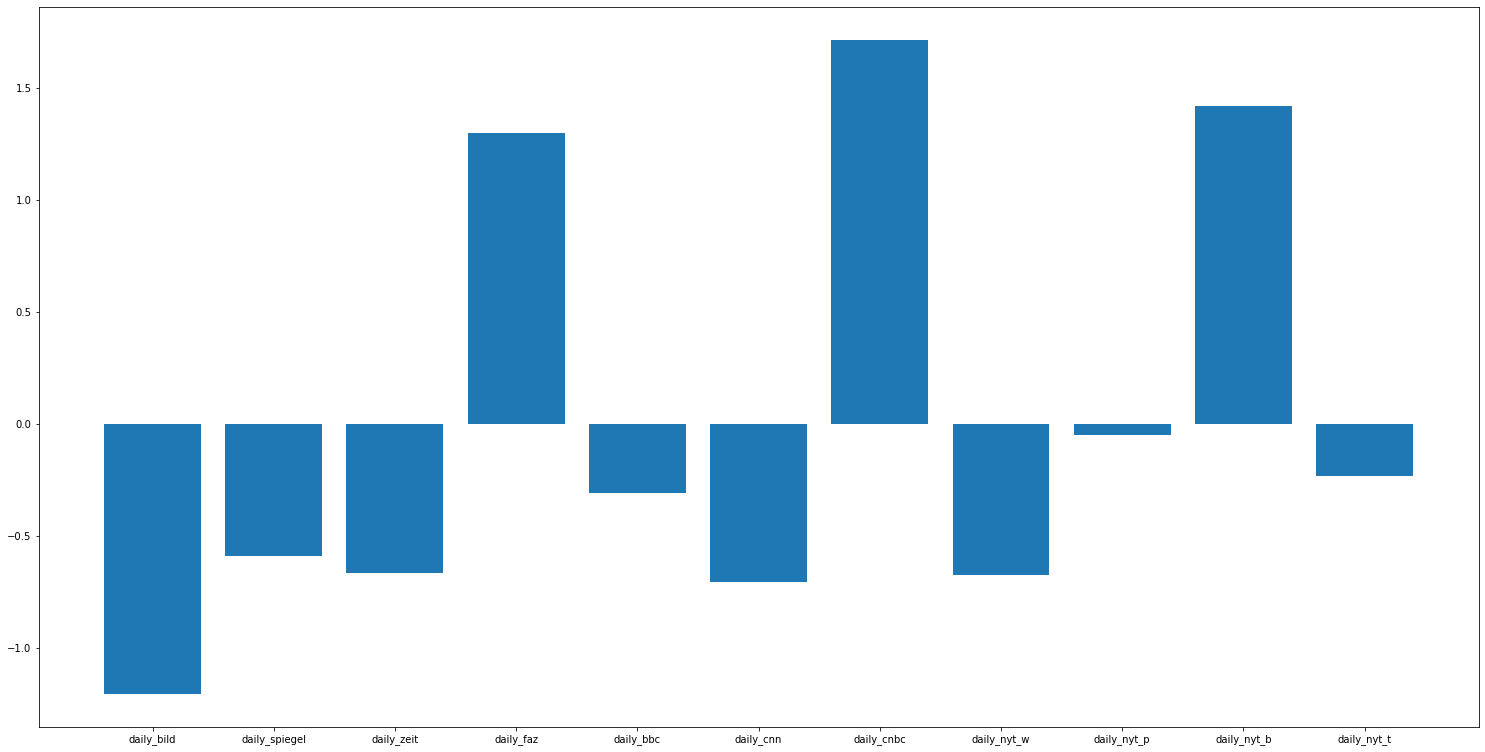

In [44]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
langs = ['daily_bild' , 'daily_spiegel', 'daily_zeit', 'daily_faz', 'daily_bbc', 'daily_cnn', 'daily_cnbc', 'daily_nyt_w', 'daily_nyt_p', 'daily_nyt_b', 'daily_nyt_t']
students = df_zscore["polarity"]
ax.bar(langs,students)
plt.show()

##### At this point this has no significance, because of its short time frame of one day
But it was expected, that 'Bild' is among the more negative connotation

## with [```pysentiment``` ](https://nickderobertis.github.io/pysentiment/)

We have two different dictionaries, namely *[Harvard IV-4](http://www.wjh.harvard.edu/~inquirer/homecat.htm)* and *[Loughran and McDonald Financial Sentiment Dictionaries](https://sraf.nd.edu/)*. Therefore we have two different *models*:

In [79]:
hiv4 = ps.HIV4()
lm = ps.LM()

Next we define our ```pyscore``` 

In [91]:
def get_pyscore(row,model):
    return pd.Series(model.get_score(model.tokenize(text=row)))

Let's use our example with Bild again:

In [109]:
bild_score_h = df_bild["bild"].apply(get_pyscore, model=hiv4)
bild_score_h.columns = ['Positive_h', 'Negative_h', 'Polarity_h', 'Subjectivity_h']
bild_score_l = df_bild["bild"].apply(get_pyscore, model=lm)
bild_score_l.columns = ['Positive_l', 'Negative_l', 'Polarity_l', 'Subjectivity_l']

bild_scores=pd.concat([bild_score_h, bild_score_l], axis=1)

In [110]:
bild_scores

,Positive_h,Negative_h,Polarity_h,Subjectivity_h,Positive_l,Negative_l,Polarity_l,Subjectivity_l
0,0.0,1.0,-0.999999,0.333333,0.0,1.0,-0.999999,0.333333
1,0.0,2.0,-1.000000,0.666666,0.0,0.0,0.000000,0.000000
2,0.0,2.0,-1.000000,1.000000,0.0,0.0,0.000000,0.000000
3,2.0,1.0,0.333333,0.750000,0.0,0.0,0.000000,0.000000
4,0.0,1.0,-0.999999,0.166667,0.0,0.0,0.000000,0.000000
5,2.0,1.0,0.333333,1.000000,0.0,1.0,-0.999999,0.333333
6,2.0,0.0,1.000000,0.500000,0.0,0.0,0.000000,0.000000
7,0.0,3.0,-1.000000,0.750000,0.0,0.0,0.000000,0.000000
8,1.0,1.0,0.000000,1.000000,0.0,1.0,-0.999999,0.500000
9,0.0,1.0,-0.999999,0.333333,0.0,0.0,0.000000,0.000000


The results seem a bit more binary in comparison to our VADER results
Also we should drop the columns *Positive* and *Negative*, because they don't have a lot of meaning to us - the polarity and subjectivity scores are aggregated from them.

In [187]:
bild_score_h = df_bild["bild"].apply(get_pyscore, model=hiv4).drop(['Positive', 'Negative'], axis=1)
bild_score_h.columns = ['Polarity_h', 'Subjectivity_h']

bild_score_l = df_bild["bild"].apply(get_pyscore, model=lm).drop(['Positive', 'Negative'], axis=1)
bild_score_l.columns = [ 'Polarity_l', 'Subjectivity_l']

In [188]:
bild_scores = pd.concat([bild_score_h, bild_score_l], axis=1)

In [189]:
bild_scores =  (bild_scores.mean().to_frame().T)

In [190]:
bild_scores.insert(loc=0, column='bild', value=daily_bild)


In [191]:
bild_scores

,bild,Polarity_h,Subjectivity_h,Polarity_l,Subjectivity_l
0,-0.165825,-0.388889,0.604166,-0.333333,0.118056


Now a bit more compact: 

In [199]:
score_h = df_bild["bild"].apply(get_pyscore, model=hiv4).drop(['Positive', 'Negative'], axis=1)
score_h.columns = ['Polarity_h', 'Subjectivity_h']

score_l = df_bild["bild"].apply(get_pyscore, model=lm).drop(['Positive', 'Negative'], axis=1)
score_l.columns = [ 'Polarity_l', 'Subjectivity_l']

scores = pd.concat([score_h, score_l], axis=1)
scores = scores.mean().to_frame().T
scores.insert(loc=0, column='bild', value=daily_bild)
bild_scores = scores

In [200]:
bild_scores

,bild,Polarity_h,Subjectivity_h,Polarity_l,Subjectivity_l
0,-0.165825,-0.388889,0.604166,-0.333333,0.118056


In [201]:
#Now for all:
#Bild
score_h = df_bild["bild"].apply(get_pyscore, model=hiv4).drop(['Positive', 'Negative'], axis=1)
score_h.columns = ['Polarity_h', 'Subjectivity_h']

score_l = df_bild["bild"].apply(get_pyscore, model=lm).drop(['Positive', 'Negative'], axis=1)
score_l.columns = [ 'Polarity_l', 'Subjectivity_l']

scores = pd.concat([score_h, score_l], axis=1)
scores =  (scores.mean().to_frame().T)
scores = scores.insert(loc=0, column='bild', value=daily_bild)
bild_scores = scores

#Spiegel
score_h = df_spiegel["spiegel"].apply(get_pyscore, model=hiv4).drop(['Positive', 'Negative'], axis=1)
score_h.columns = ['Polarity_h', 'Subjectivity_h']

score_l = df_spiegel["spiegel"].apply(get_pyscore, model=lm).drop(['Positive', 'Negative'], axis=1)
score_l.columns = [ 'Polarity_l', 'Subjectivity_l']

scores = pd.concat([score_h, score_l], axis=1)
scores =  (scores.mean().to_frame().T)
scores.insert(loc=0, column='spiegel', value=daily_spiegel)
spiegel_scores = scores

#Zeit
score_h = df_zeit["zeit"].apply(get_pyscore, model=hiv4).drop(['Positive', 'Negative'], axis=1)
score_h.columns = ['Polarity_h', 'Subjectivity_h']

score_l = df_zeit["zeit"].apply(get_pyscore, model=lm).drop(['Positive', 'Negative'], axis=1)
score_l.columns = [ 'Polarity_l', 'Subjectivity_l']

scores = pd.concat([score_h, score_l], axis=1)
scores =  (scores.mean().to_frame().T)
scores.insert(loc=0, column='zeit', value=daily_zeit)
zeit_scores = scores

#FAZ
score_h = df_faz["faz"].apply(get_pyscore, model=hiv4).drop(['Positive', 'Negative'], axis=1)
score_h.columns = ['Polarity_h', 'Subjectivity_h']

score_l = df_faz["faz"].apply(get_pyscore, model=lm).drop(['Positive', 'Negative'], axis=1)
score_l.columns = [ 'Polarity_l', 'Subjectivity_l']

scores = pd.concat([score_h, score_l], axis=1)
scores =  (scores.mean().to_frame().T)
scores.insert(loc=0, column='faz', value=daily_faz)
faz_scores = scores

#BBC
score_h = df_bbc["bbc"].apply(get_pyscore, model=hiv4).drop(['Positive', 'Negative'], axis=1)
score_h.columns = ['Polarity_h', 'Subjectivity_h']

score_l = df_bbc["bbc"].apply(get_pyscore, model=lm).drop(['Positive', 'Negative'], axis=1)
score_l.columns = [ 'Polarity_l', 'Subjectivity_l']

scores = pd.concat([score_h, score_l], axis=1)
scores =  (scores.mean().to_frame().T)
scores.insert(loc=0, column='bbc', value=daily_bbc)
bbc_scores = scores

#CNN
score_h = df_cnn["cnn"].apply(get_pyscore, model=hiv4).drop(['Positive', 'Negative'], axis=1)
score_h.columns = ['Polarity_h', 'Subjectivity_h']

score_l = df_cnn["cnn"].apply(get_pyscore, model=lm).drop(['Positive', 'Negative'], axis=1)
score_l.columns = [ 'Polarity_l', 'Subjectivity_l']

scores = pd.concat([score_h, score_l], axis=1)
scores =  (scores.mean().to_frame().T)
scores.insert(loc=0, column='cnn', value=daily_cnn)
cnn_scores = scores

#CNBC
score_h = df_cnbc["cnbc"].apply(get_pyscore, model=hiv4).drop(['Positive', 'Negative'], axis=1)
score_h.columns = ['Polarity_h', 'Subjectivity_h']

score_l = df_cnbc["cnbc"].apply(get_pyscore, model=lm).drop(['Positive', 'Negative'], axis=1)
score_l.columns = [ 'Polarity_l', 'Subjectivity_l']

scores = pd.concat([score_h, score_l], axis=1)
scores =  (scores.mean().to_frame().T)
scores.insert(loc=0, column='cnbc', value=daily_cnbc)
cnbc_scores = scores

#NYT World
score_h = df_nyt_w["nyt_w"].apply(get_pyscore, model=hiv4).drop(['Positive', 'Negative'], axis=1)
score_h.columns = ['Polarity_h', 'Subjectivity_h']

score_l = df_nyt_w["nyt_w"].apply(get_pyscore, model=lm).drop(['Positive', 'Negative'], axis=1)
score_l.columns = [ 'Polarity_l', 'Subjectivity_l']

scores = pd.concat([score_h, score_l], axis=1)
scores =  (scores.mean().to_frame().T)
scores.insert(loc=0, column='nyt_w', value=daily_nyt_w)
nyt_w_scores = scores

#NYT Politics
score_h = df_nyt_p["nyt_p"].apply(get_pyscore, model=hiv4).drop(['Positive', 'Negative'], axis=1)
score_h.columns = ['Polarity_h', 'Subjectivity_h']

score_l = df_nyt_p["nyt_p"].apply(get_pyscore, model=lm).drop(['Positive', 'Negative'], axis=1)
score_l.columns = [ 'Polarity_l', 'Subjectivity_l']

scores = pd.concat([score_h, score_l], axis=1)
scores =  (scores.mean().to_frame().T)
scores.insert(loc=0, column='nyt_p', value=daily_nyt_p)
nyt_p_scores = scores

#NYT Business
score_h = df_nyt_b["nyt_b"].apply(get_pyscore, model=hiv4).drop(['Positive', 'Negative'], axis=1)
score_h.columns = ['Polarity_h', 'Subjectivity_h']

score_l = df_nyt_b["nyt_b"].apply(get_pyscore, model=lm).drop(['Positive', 'Negative'], axis=1)
score_l.columns = [ 'Polarity_l', 'Subjectivity_l']

scores = pd.concat([score_h, score_l], axis=1)
scores =  (scores.mean().to_frame().T)
scores.insert(loc=0, column='nyt_b', value=daily_nyt_b)
nyt_b_scores = scores

#NYT Tech
score_h = df_nyt_t["nyt_t"].apply(get_pyscore, model=hiv4).drop(['Positive', 'Negative'], axis=1)
score_h.columns = ['Polarity_h', 'Subjectivity_h']

score_l = df_nyt_t["nyt_t"].apply(get_pyscore, model=lm).drop(['Positive', 'Negative'], axis=1)
score_l.columns = [ 'Polarity_l', 'Subjectivity_l']

scores = pd.concat([score_h, score_l], axis=1)
scores =  (scores.mean().to_frame().T)
scores.insert(loc=0, column='nyt_t', value=daily_nyt_t)
nyt_t_scores = scores

# 4. Upload on our MySQL Database <a id="4"></a>

Let's finally merge our results from our sentiment analysis and add a timestamp

In [202]:
daily_scores = pd.concat([bild_scores, spiegel_scores, zeit_scores, faz_scores, bbc_scores, cnn_scores, cnbc_scores, nyt_w_scores, nyt_p_scores, nyt_b_scores, nyt_t_scores], axis=1, sort=False)

In [203]:
n = pd.to_datetime('today').strftime("%m/%d/%Y")
n

'10/29/2020'

##### Lets add a Timestamp so we can use the Headlines as Timeseries

In [204]:
daily_scores.insert(loc=0, column='Timestamp', value=n)

In [205]:
daily_scores

,Timestamp,spiegel,Polarity_h,Subjectivity_h,Polarity_l,Subjectivity_l,zeit,Polarity_h,Subjectivity_h,Polarity_l,...,nyt_b,Polarity_h,Subjectivity_h,Polarity_l,Subjectivity_l,nyt_t,Polarity_h,Subjectivity_h,Polarity_l,Subjectivity_l
0,10/29/2020,-0.117319,-0.074074,0.339286,-0.259259,0.154938,-0.123405,-0.2,0.345833,-0.2,...,0.040724,0.117647,0.310891,-0.147059,0.083438,-0.089235,-0.086956,0.282618,-0.347826,0.168516


In [206]:
############### CONFIGURE THIS ###################
# Open database connection

# Credentials to database connection
user = 'sql7372795'
passw = 'tbd'
host =  'sql7.freemysqlhosting.net'
database = 'sql7372795'


# Create SQLAlchemy engine to connect to MySQL Database
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=host, db=database, user=user, pw=passw))

In [207]:
daily_scores.to_sql('scores', engine, if_exists = 'append')

Now we could schedule daily parsing and uploads!

# 5. Schedule daily runs as .py script <a id="5"></a>

##### To create our final database, we will run the crucial parts of our notebook as a .py script 

- HTML Parsing
- Daily ```VADER``` Scores
- Daily ```Pysentiment``` Scores 
- Upload (```append```) to our MySQL Database

All the parts of our exploratory data analysis are obviously not needed for the daily runs.

# 6. Upcoming Analysis of our unique dataset <a id="6"></a>

##### Our main goal is to compares our different scores of our timeseries against german (and US) financial markets

We will compare:
- ```VADER``` Score
- Popularity and Subjectivity ```Pysentiment HIV-4``` Scores 
- Popularity and Subjectivity ```Pysentiment LM``` Scores 

I am very excited to see our results in a view months!

# 7. Outlook <a id="7"></a>

The preliminary results of our ```VADER```  and ```pysentiment``` analysis are quite encouraging. But we will have to wait until our dataset has a statistically significant size.

# Thank you for completing this Notebook!

<hr>
<h5>
<p> <center>  <font color='gray'> Jupyter Notebook by </font> Jonas Gottal </center></p>
</h5>